In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [411]:
# Load look-up table
lut = pd.read_csv(const.LOOK_UP_TABLE)
lut.head()

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,station_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,0.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,0.0
3,0,0,6,7.0,L0_S0_D7,NaN,L0_S0_F6,0.0
4,0,0,8,9.0,L0_S0_D9,NaN,L0_S0_F8,0.0


In [413]:
lut.station_V2.unique()

array([  0.   ,   1.   ,   2.   ,   3.   ,   4.   ,   5.   ,   6.   ,
         7.   ,   8.   ,   9.   ,  10.   ,  11.   ,  12.   ,  13.   ,
        14.   ,  15.   ,  16.   ,  17.   ,  18.   ,  19.   ,  20.   ,
        21.   ,  22.   ,  23.   ,  24.1  ,  24.101,  24.102,  24.103,
        24.104,  24.105,  24.106,  24.107,  24.108,  24.109,  24.11 ,
        24.111,  24.112,  24.2  ,  24.201,  24.202,  24.203,  24.204,
        24.205,  24.206,  24.207,  24.208,  24.209,  24.21 ,  24.211,
        24.3  ,  24.301,  24.302,  24.303,  24.304,  24.305,  24.306,
        24.307,  24.308,  24.309,  24.31 ,  24.311,  25.1  ,  25.101,
        25.102,  25.103,  25.104,  25.105,  25.106,  25.107,  25.108,
        25.109,  25.11 ,  25.2  ,  25.201,  25.202,  25.203,  25.204,
        25.205,  25.206,  25.207,  25.208,  25.209,  25.21 ,  25.211,
        25.212,  25.213,  25.214,  25.215,  25.216,  25.217,  25.218,
        25.219,  25.22 ,  25.221,  25.222,  25.223,  25.224,  25.225,
        25.226,  25.

In [414]:
# Load unique paths and covert them to dataframe
paths = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_unique_paths_station.csv'), index_col=0)

# Convert strings to int array (could not find a way to split the characters in string other than this...)
paths = (paths.u_str.str.replace('0','0,').str.replace('1','1,').str.split(',')).apply(pd.Series)

# Drop last column (residue after split)
paths.drop(paths.columns[-1], axis=1, inplace=True)

# To ints
paths = paths.astype(int)

# Replace index by station_V2 numbers
paths.columns = lut.groupby('station_V2').station_V2.first().reset_index(drop=True).values

paths.head(3)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1


In [416]:
paths.shape

(15210, 129)

In [402]:
# Load unique path per sample ID
string_id_to_pid = pd.read_csv(os.path.join(const.DATA_PATH, 'eda_product_flow_sample_paths_station.csv'))

In [403]:
string_id_to_pid.head(3)

,id,u_arr_ix
0,4,13409
1,6,7029
2,7,12763


In [404]:
# Load response
y=func.read_last_column('train_numeric.csv')#[:500000]
y.head(3)

,Response
Id,
4,0
6,0
7,0


## Calculate clusters

In [7]:
from sklearn.cluster import KMeans

In [300]:
nclus = 100
km = KMeans(nclus, n_init=100, max_iter=100, random_state=11111)

In [301]:
km.fit(paths)

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=100,
    n_init=100, n_jobs=1, precompute_distances='auto', random_state=11111,
    tol=0.0001, verbose=0)

In [302]:
km.predict(paths)

array([ 1, 39, 39, ..., 97, 22, 97], dtype=int32)

In [303]:
km.predict(paths).shape

(15210,)

In [304]:
clusters = pd.DataFrame(pd.Series(km.labels_), index=paths.index, columns=['cluster'])

In [305]:
clusters.head(3)

,cluster
id,
0,1
1,39
2,39


In [488]:
def cluster_unique_paths(unique_paths, n_clus):
    ''' Function to cluster set of unique paths '''
    
    # Cluster using Kmeans
    km = KMeans(n_clus, n_init=100, max_iter=100, random_state=11111)
    km.fit(unique_paths)
    
    # Return DataFrame
    clusters = pd.DataFrame(pd.Series(km.labels_), 
                            index=unique_paths.index, 
                            columns=['cluster'])
    
    return clusters

def visualize_cluster_result(unique_paths, clusters, sample_to_path, y):
    
    nclus = clusters['cluster'].nunique()
    
    cluster_per_sample = sample_to_path.merge(unique_paths, 
                                   left_on='u_arr_ix', 
                                   right_index=True, 
                                   how='left') \
                            .merge(clusters,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') \
                            .drop(['u_arr_ix','id'], axis=1)
    
    
    cluster_grouped = cluster_per_sample.groupby('cluster').mean()
    # Fix weird rounding bug
    cluster_grouped.columns = [round(n,3) for n in cluster_grouped.columns]
    
                    
    # Get sorting index based on major thresholds
    try:
        so = (cluster_grouped>0.85).sort_values([0.0, 12.0, 24.1, 24.2, 24.3, 25.1, 25.202, 25.212, 25.222, 26.0, 27.0])
    except:
        print('Error sorting values')
        so = (cluster_grouped>0.85)
    
    
    # Visualize major stations per cluster
    plt.figure(figsize=(24,8))
    ax = sns.heatmap(cluster_per_sample.groupby('cluster').mean().loc[so.index,:], cmap='Blues')
    ax.set_title('Number of clusters: {}'.format(nclus))
    
    cluster_per_sample['R'] = y
    
    # Create dataframe with results
    cluster_summary = pd.DataFrame({'meanR': cluster_per_sample.groupby('cluster').R.mean(),
                                'sample_count': cluster_per_sample.groupby('cluster').R.count()},
                               index=range(nclus))
    cluster_summary.sort_values('sample_count', ascending=False, inplace=True)
    
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8), sharex=True)
    cluster_summary['meanR'].plot(kind='bar', ax=ax1)
    ax1.set_title('Number of clusters: {}'.format(nclus))
    ax1.set_ylabel('Error rate')
    cluster_summary['sample_count'].apply(lambda x: np.log10(x)).plot(kind='bar', ax=ax2)
    ax2.set_ylabel('log10(Sample count)')
    ax2.set_xlabel('Cluster number')
    
    return cluster_summary

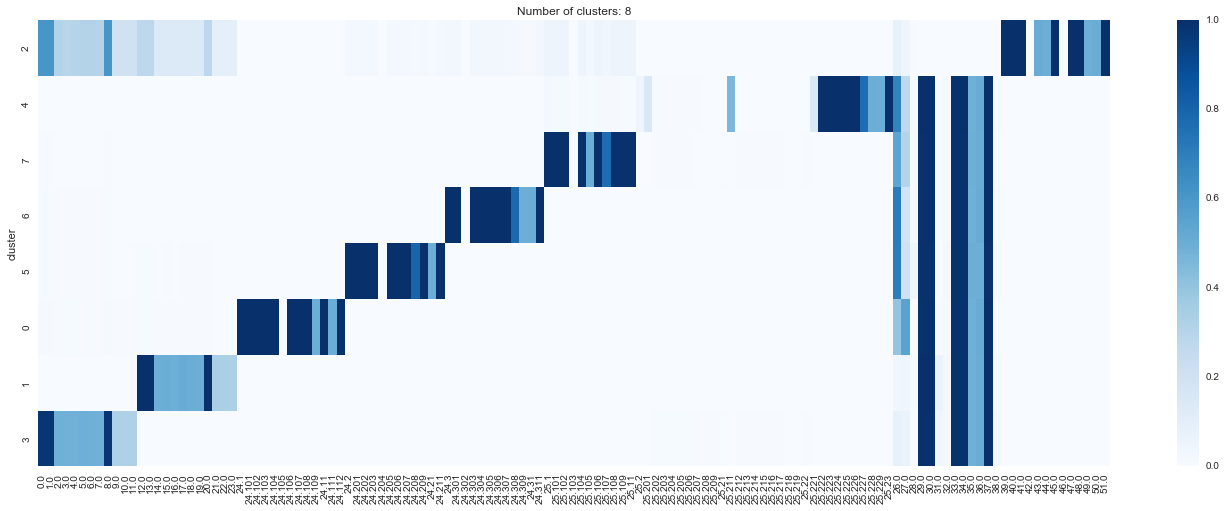

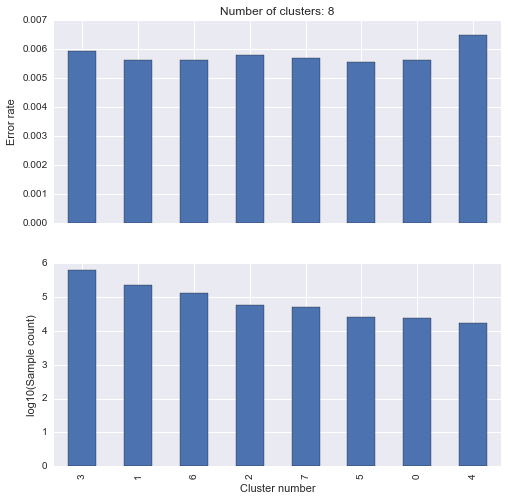

In [471]:
clusters_8 = cluster_unique_paths(paths, 8)
summary_8 = visualize_cluster_result(paths, clusters_8, string_id_to_pid, y)

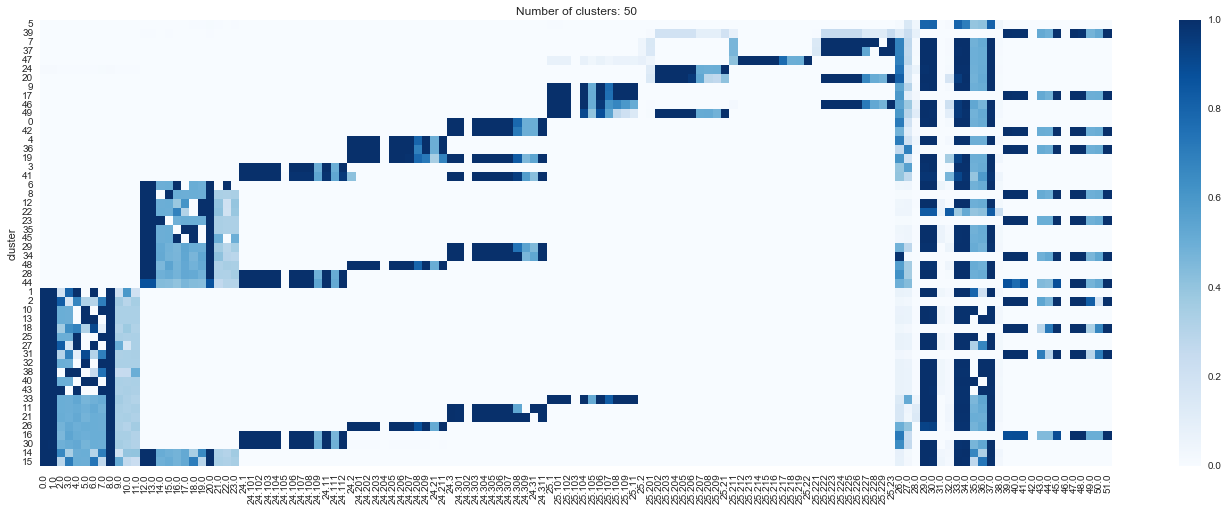

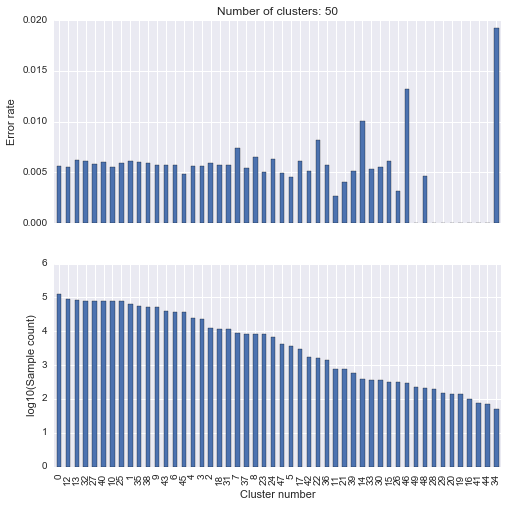

In [472]:
clusters_50 = cluster_unique_paths(paths, 50)
summary_50 = visualize_cluster_result(paths, clusters_50, string_id_to_pid, y)

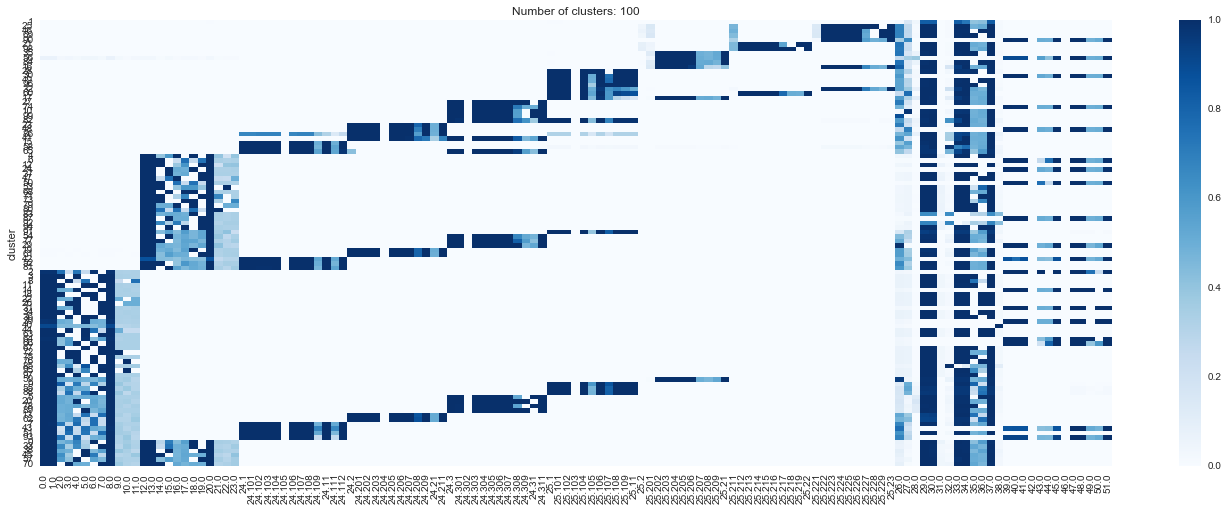

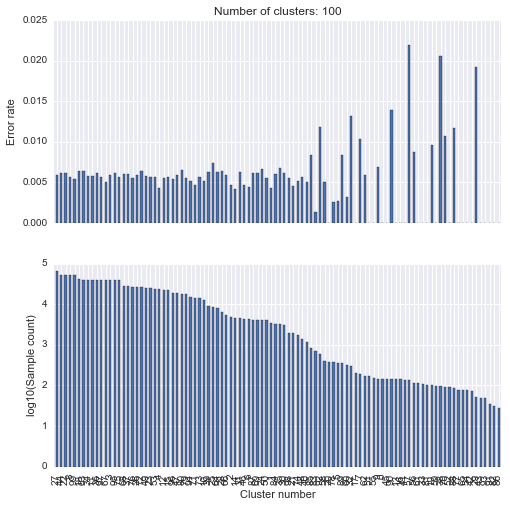

In [474]:
clusters_100 = cluster_unique_paths(paths, 100)
summary_100 = visualize_cluster_result(paths, clusters_100, string_id_to_pid, y)

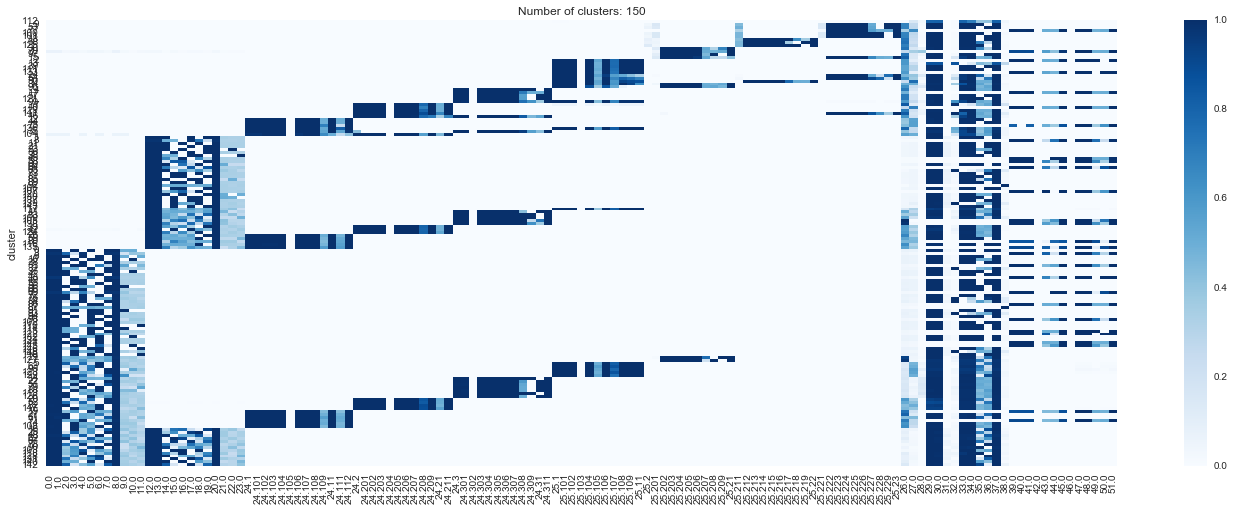

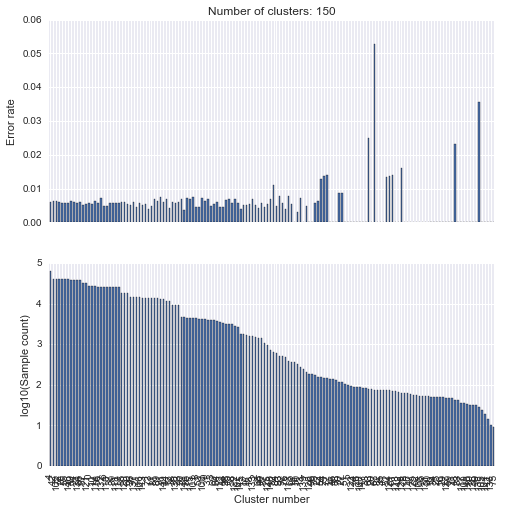

In [478]:
clusters_150 = cluster_unique_paths(paths, 150)
summary_150 = visualize_cluster_result(paths, clusters_150, string_id_to_pid, y)

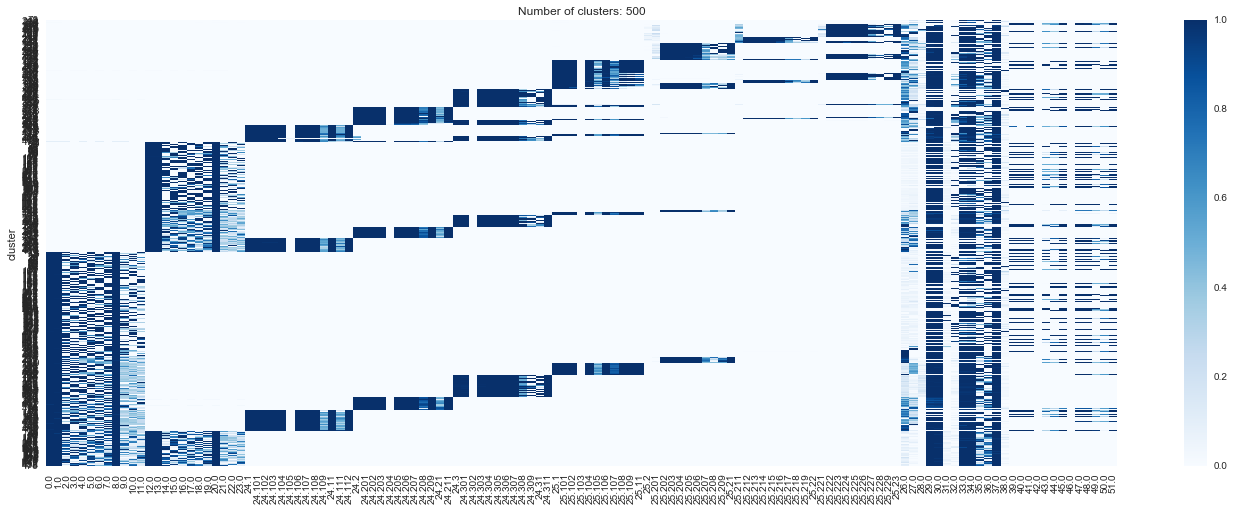

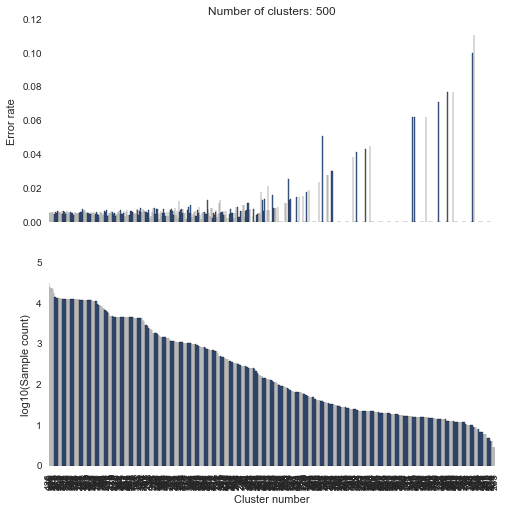

In [479]:
clusters_500 = cluster_unique_paths(paths, 500)
summary_500 = visualize_cluster_result(paths, clusters_500, string_id_to_pid, y)

In [481]:
pid_to_cluster = string_id_to_pid.merge(clusters_8,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left')
pid_to_cluster = pid_to_cluster.merge(clusters_50,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left')
pid_to_cluster = pid_to_cluster.merge(clusters_100,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') 
pid_to_cluster = pid_to_cluster.merge(clusters_500,
                                   left_on='u_arr_ix',
                                   right_index=True,
                                   how='left') 
pid_to_cluster.set_index('id', inplace=True)
pid_to_cluster.columns = ['unique_path','cluster_n8','cluster_n50', 'cluster_n100', 'cluster_n500']

In [482]:
pid_to_cluster.head(3)

,unique_path,cluster_n8,cluster_n50,cluster_n100,cluster_n500
id,,,,,
4,13409,3,25,3,127
6,7029,1,45,80,20
7,12763,3,40,11,348


In [483]:
pid_to_cluster.to_csv(os.path.join(const.DATA_PATH, 'eda_sample_clusters.csv'), index_label='Id')

### Try to cluster only line 3

In [480]:
paths.columns.get_loc(26.)

103

Error sorting values


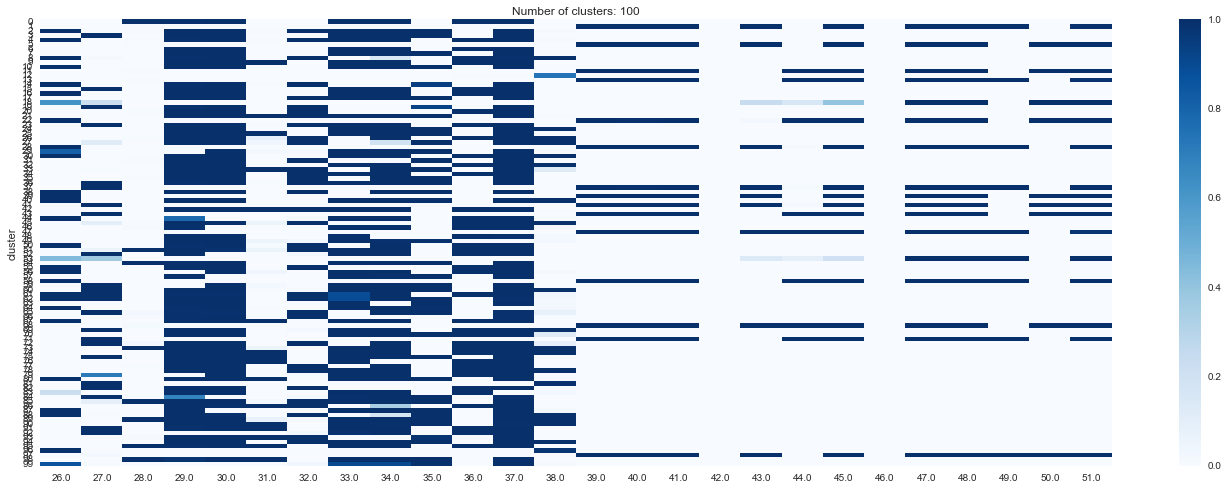

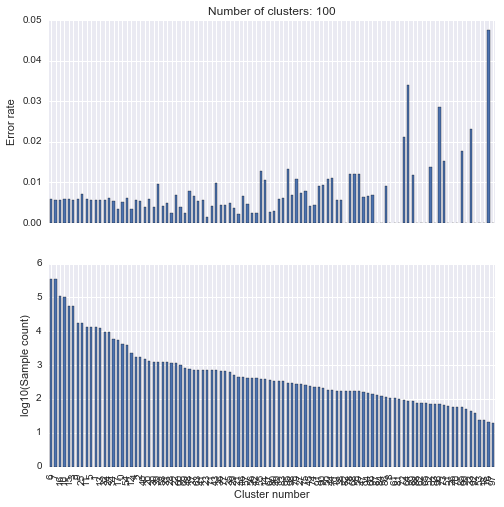

In [490]:
clusters_line_3 = cluster_unique_paths(paths.iloc[:, 103:], 100)
summary_line_3 = visualize_cluster_result(paths.iloc[:, 103:], clusters_line_3, string_id_to_pid, y)